Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0328 - val_loss: 3.6294e-04 - val_mean_absolute_error: 0.0123
Epoch 2/20
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 3.5818e-04 - mean_absolute_error: 0.0126 - val_loss: 3.7735e-04 - val_mean_absolute_error: 0.0119
Epoch 3/20
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 3.5417e-04 - mean_absolute_error: 0.0124 - val_loss: 3.5757e-04 - val_mean_absolute_error: 0.0112
Epoch 4/20
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 3.5078e-04 - mean_absolute_error: 0.0123 - val_loss: 3.9231e-04 - val_mean_absolute_error: 0.0130
Epoch 5/20
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 3.5291e-04 - mean_absolute_error: 0.0123 - val_loss: 3.5697e-04 - val_mean_absolute_error: 0.0117
Epoch 6/20
3634/3634 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 3.1770e-04 - mean_absolute_error: 0.0117 - val_loss: 3.4018e-04 - val_mean_absolute_error: 0.0115
Epoch 7/20
3634/3634 ━━━━━━━━━━━━━━━━━

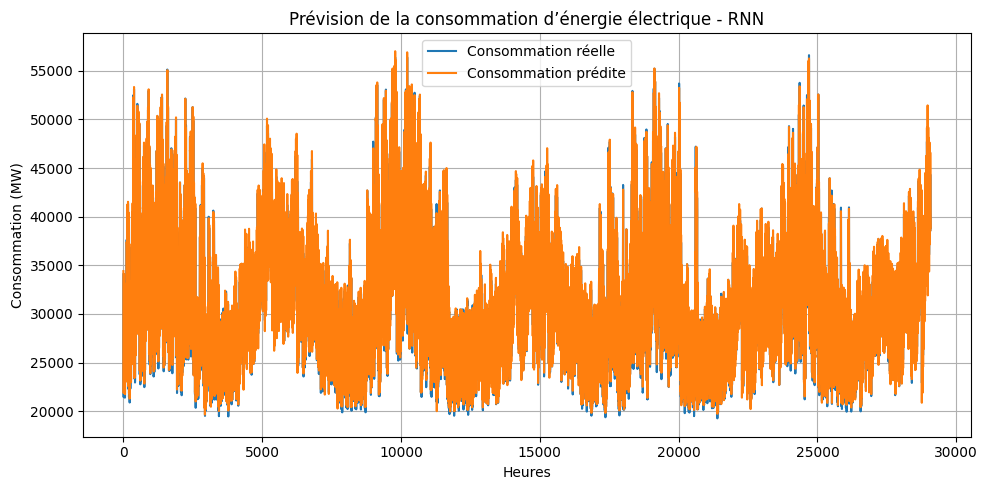

In [ ]:
# TP4 - Prévision de la consommation d'énergie électrique avec RNN

# Partie 1 : Chargement et préparation des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import Input

# Charger le dataset PJME_hourly
data = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
consumption = data['PJME_MW'].values.reshape(-1, 1)

# Partie 2 : Normalisation

scaler = MinMaxScaler()
scaled = scaler.fit_transform(consumption)

# Partie 3 : Création des séquences temporelles
def create_sequences(data, seq_len=24):  # 24 heures pour capturer les motifs quotidiens
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_length = 24  # Utiliser 24 heures comme fenêtre temporelle
X, y = create_sequences(scaled, seq_length)

# Partie 4 : Séparation en ensembles d’entraînement et de test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Partie 5 : Définition du modèle RNN

model = Sequential([
    Input(shape=(seq_length, 1)),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
model.summary()

# Partie 6 : Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Partie 7 : Prédiction et dénormalisation
pred = model.predict(X_test)
pred_consumption = scaler.inverse_transform(pred)
true_consumption = scaler.inverse_transform(y_test)

# Partie 8 : Visualisation des résultats
plt.figure(figsize=(10, 5))
plt.plot(true_consumption, label='Consommation réelle')
plt.plot(pred_consumption, label='Consommation prédite')
plt.title('Prévision de la consommation d’énergie électrique - RNN')
plt.xlabel('Heures')
plt.ylabel('Consommation (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('rnn_energy_forecast.png')

# Partie 9 : Sauvegarde et réutilisation du modèle
model.save('rnn_energy_model.keras')

# Partie 10 : Chargement et prédiction sur nouvelles données
from tensorflow.keras.models import load_model
loaded_model = load_model('rnn_energy_model.keras')

# Utiliser une partie des données existantes comme "nouvelles données" (par exemple, les 100 dernières heures)
new_data = data.tail(100)  # Prendre les 100 dernières heures
new_consumption = new_data['PJME_MW'].values.reshape(-1, 1)
new_scaled = scaler.transform(new_consumption)

# Vérifier qu'il y a assez de points pour une prédiction
if len(new_scaled) > seq_length:
    X_new, _ = create_sequences(new_scaled, seq_length)
    pred_new = loaded_model.predict(X_new)
    pred_new_consumption = scaler.inverse_transform(pred_new)
    print("Prévision pour nouvelles données :")
    print(pred_new_consumption)
else:
    print(f"⚠ Pas assez de données pour faire une prédiction (besoin d’au moins {seq_length+1} points, seulement {len(new_scaled)} fournis).")